# This notebook contains notes on all steps necessary to understand encoder-decoder architecture with attention that uses LSTMs as building blocks.

## 1. Keras basics
Keras gives simple API to programming neural networks with tensorflow. This section will provide quick overview of most important features used in code. More detailed explanations can be found [here](https://www.tensorflow.org/guide/keras). Important feature (in terms of understanding Keras code) is that Keras doesn't need input shape of NN to be specified, it can be determined during runtime, so usually Input layer is omitted.
### How to create models - Sequential model
Sequential model provides simple way to program neural networks that can be modeled as stack of layers. Example code that models NN with hidden layer of 3 neurons (relu activation) and output of 2 neurons:

In [3]:
from tensorflow import keras
import tensorflow as tf

model = keras.Sequential(
    [
        keras.layers.Dense(3, activation="relu", name="hidden"),
        keras.layers.Dense(2, name="output"),
    ])

Model created above can be called on input $x$ with shape 3x3 (for example batch_size x n_features)

In [4]:
x = tf.ones((3, 3))
y = model(x)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (Dense)              (3, 3)                    12        
                                                                 
 output (Dense)              (3, 2)                    8         
                                                                 
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________




Another way to create such model is to create and add layers separately.

In [7]:
model = keras.Sequential()
hidden = keras.layers.Dense(3, activation="relu", name="hidden")
model.add(hidden)
out = keras.layers.Dense(2, name="output")
model.add(out)


x = tf.ones((3, 3))
y = model(x)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (Dense)              (3, 3)                    12        
                                                                 
 output (Dense)              (3, 2)                    8         
                                                                 
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


## How to create models - Functional API
Functional API enables creation of more complicated models - ones that cannot be modeled as stack of layers (for example ones that take more than one input). Let's create model that takes 10-dimensional vector as input, feeds it into dense layer with 4 neurons and outputs 1 neuron. Here we create layers separately and link them using call operator. Since here input is defined explicitly, we can show summary before feeding real data to model - that's why layer output shapes have None - to accommodate batch size. 

In [28]:
inputs = keras.Input(shape=(10,), name="inputs")
hidden = keras.layers.Dense(4, activation="relu", name="hidden")(inputs)
out = keras.layers.Dense(1, activation="linear", name="out")(hidden)
model = keras.Model(inputs=inputs, outputs=out)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 10)]              0         
                                                                 
 hidden (Dense)              (None, 4)                 44        
                                                                 
 out (Dense)                 (None, 1)                 5         
                                                                 
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


## How to train models
To train model, first it needs to be compiled. We can specify optimizer used and cost function.

In [23]:

model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.MeanSquaredError())

Then we can fit model. Train data, validation data, batch size and number of epochs can be specified. Train data can be either passed as x_train and y_train or as tf.dataset

In [25]:
# prepare data
x_train = tf.ones((10, 10))
y_train = tf.ones((10, 1))
x_val = tf.ones((1, 10))
y_val = tf.ones((1, 1))

print("fit by passing x_train, y_train")
model.fit(x_train, y_train, batch_size=2,  epochs=1, validation_data=(x_val, y_val))

print("fit with dataset")
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(2)
model.fit(dataset, epochs=1)

fit by passing x_train, y_train
5/5 [==============================] - 0s 18ms/step - loss: 0.9075 - val_loss: 0.9018
fit with dataset
5/5 [==============================] - 0s 2ms/step - loss: 0.8980


## 2. Dense NNs vs RNNs
Note: biases are omitted in all calculations and pictures to simplify a little bit

### Simplest case - Dense Neural Network
The simplest NN is a dense one - it takes some inputs $x$, has some hidden neurons $h$ and produces some output $y$. It has 2 sets of weights:
- $W_{xh}$ that are applied to input
- $W_{hy}$ that are applied to hidden state before producing output
  
Picture below portraits dense neural network with one hidden layer

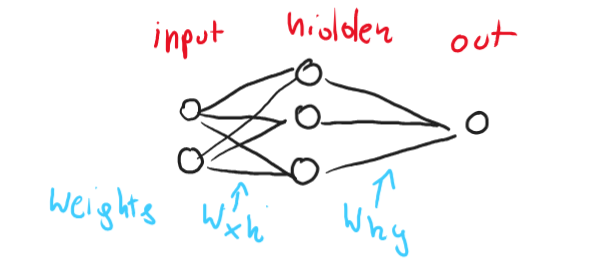

Or, in simplified form it can be pictured as:

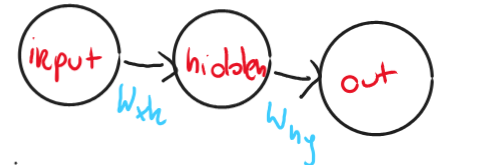

During forward pass such neural network does following computations:
1) compute hidden activations $h = tanh(x \cdot W_{xh})$*
2) produce output $ y = h \cdot W_{hy}$
   
\* tanh is used as activation function, but it can be anything (relu/sigmoid)

In dense NNs hidden layer can have different shape than input. If for example we have 10-dimensional input, 4 hidden neurons and 1 output, shapes of NN components are:
- $x$ = (n_batches, 10) - input
- $W_{xh}$ = (10, 4)
- $h$ = (n_batches, 4) - hidden layer output
- $W_{hy}$ = (4, 1)
- $y$ = (n_batches, 1) - output

Below is example code that defines such network

In [29]:
inputs = keras.Input(shape=(10,), name="inputs")
hidden = keras.layers.Dense(4, activation="relu", name="hidden")(inputs)
out = keras.layers.Dense(1, activation="linear", name="out")(hidden)
model = keras.Model(inputs=inputs, outputs=out)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 10)]              0         
                                                                 
 hidden (Dense)              (None, 4)                 44        
                                                                 
 out (Dense)                 (None, 1)                 5         
                                                                 
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


To apply dense NNs for time series prediction, first data needs to be properly prepared due to the fact, that dense NNs take input of fixed size. If for example we have 14 data points and we want to predict 1 timestamp ahead based on 10 previous timestamps, 3 training samples would be generated from our dataset.

In [42]:
import numpy as np
window_size = 10

raw_data = np.random.rand(14)
dataset = np.lib.stride_tricks.sliding_window_view(raw_data[:-1], (window_size + 1, ))
x = dataset[:, :-1]
y = dataset[:, -1]
print(f'X shape: {x.shape}, Y shape: {y.shape}. Got {y.shape[0]} batches')

X shape: (3, 10), Y shape: (3,). Got 3 batches


### Recurrent Neural Networks
Most basic RNN can be defined as series of cells, where each cell takes input $x$, returns output $y$ and in each time step passes hidden state $h$ to next time step. This neural network architecture includes 3 sets of weights: 
- $W_{hh}$ that are applied to hidden state passed from previous timestep
- $W_{xh}$ that are applied to input at each timestep
- $W_{hy}$ that are applied to hidden state before producing output at each timestep


Below picture shows whole architecture in a compact way.

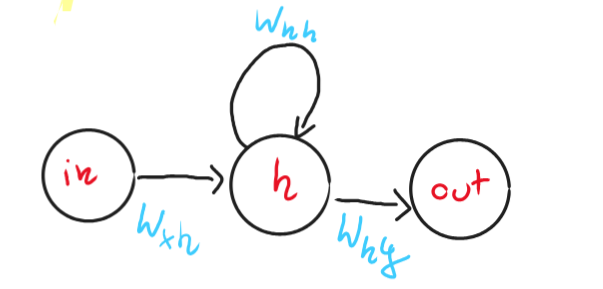

One of the most important concepts in RNNs is unrolling - that means picturing network cells for different timestamps as separate neurons. Below picture shows network presented above unrolled for 3 timesteps.

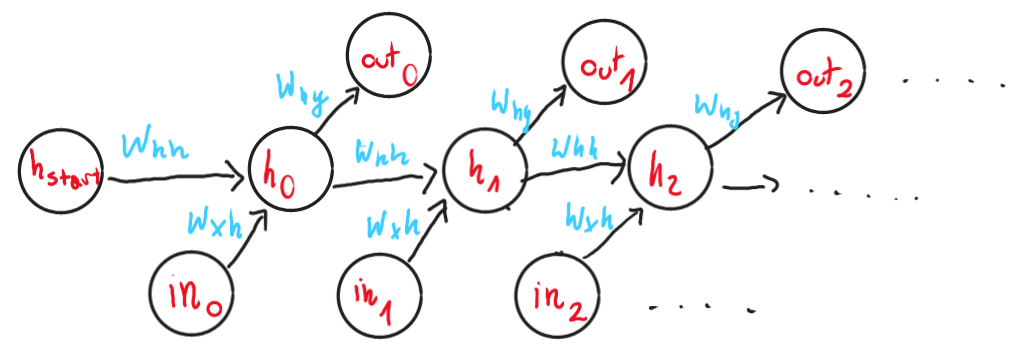


Network takes as input initial hidden state -  $h_{start}$, usually initialized to 0.
In timestep $t = 1$ network takes two inputs - $h_0$ (hidden state from previous timestep) and $x_1$ (input at timestep 1), produces two outputs - $h_1$ that is passed to next timestep and $y_1$ that is output for this timestep.

During forward pass at timestep $t$ such neural network does following computations:
1) calculate hidden activations $h_t = tanh(W_{hh} \cdot h_{t - 1} + W_{xh} \cdot x_t )$*
2) produce output $ y_t = h_t \cdot W_{hy}$

\* tanh is used as activation function, but it can be anything (relu/sigmoid)

These steps are calculated at each timestep using the same wieghts. 

Like in dense NNs, hidden layer can have different shape than input. If for example we have 1-D input, 4 hidden units, which implies 4-D output. If we want to get 1-D output dense layer on top of RNN is required. Shapes of whole network (RNN + Dense) components are:

Shapes below are result of setting return_sequences for RNN to False - that means that RNN layer will return only last output

- $x$ = (n_batches, n_timesteps, 1) - input
- $W_{xh}$ = (1, 4)
- $h$ = (1, 4) - hidden layer output - calculated at each step
- $W_{hy}$ = (4, 4)
- $W_{hy}$ = (4, 4)
- $y_{hidden}$ = (n_batches, 4) - output - result of running n_batches through RNN
- $W_{dense}$ = (4,  1) - weights of dense layer
- $y_{dense}$ = (n_batches, 1) - output

If we set return_sequences to True shapes are as follows:

- $x$ = (n_batches, n_timesteps, 1) - input
- $W_{xh}$ = (1, 4)
- $h$ = (1, 4) - hidden layer output - calculated at each step
- $W_{hy}$ = (4, 4)
- $W_{hy}$ = (4, 4)
- $y_{hidden}$ = (n_batches, n_timesteps, 4) - output - result of running n_batches through RNN
- $W_{dense}$ = (4,  1) - weights of dense layer, applied at each timestep
- $y_{dense}$ = (n_batches, n_timesteps, 1) - output


Below is example code that defines such networks

In [48]:
timesteps = 5
# not returning sequences
inputs = keras.Input(shape=(timesteps, 1), name="inputs")
hidden = keras.layers.SimpleRNN(4, name="hidden", return_sequences=False)(inputs)
out = keras.layers.Dense(1, activation="linear", name="out")(hidden)
model = keras.Model(inputs=inputs, outputs=out)
model.summary()
# returning sequences
inputs = keras.Input(shape=(timesteps, 1), name="inputs")
hidden = keras.layers.SimpleRNN(4, name="hidden", return_sequences=True)(inputs)
out = keras.layers.Dense(1, activation="linear", name="out")(hidden)
model = keras.Model(inputs=inputs, outputs=out)
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 5, 1)]            0         
                                                                 
 hidden (SimpleRNN)          (None, 4)                 24        
                                                                 
 out (Dense)                 (None, 1)                 5         
                                                                 
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 5, 1)]            0         
                                                                 
 hidden (SimpleRNN)          (None, 5, 4)   